In [1]:
## Import needed libraries
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import pylab   as plt

In [2]:
# hSBM specific libraries
from sbmtm import sbmtm
import graph_tool.all as gt

In [3]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [4]:
file = open('hSBM_demogr_model.pickle', 'rb')
model = pickle.load(file)

In [5]:
# The hierarchical levels themselves are represented by individual BlockState() instances
levels = model.state.get_levels()
for s in levels:
    print(s)
    if s.get_N() == 1:
        break

<BlockState object with 38424 blocks (10 nonempty), degree-corrected, for graph <Graph object, undirected, with 38424 vertices and 73993 edges, 2 internal vertex properties, at 0x7f0a544a6f40>, at 0x7f0a3158ca30>
<BlockState object with 8 blocks (5 nonempty), for graph <Graph object, undirected, with 38424 vertices and 14 edges, at 0x7f0a30ca0460>, at 0x7f0a30ca0610>
<BlockState object with 4 blocks (2 nonempty), for graph <Graph object, undirected, with 8 vertices and 5 edges, at 0x7f0a30ca1490>, at 0x7f0a30ca0d30>
<BlockState object with 2 blocks (1 nonempty), for graph <Graph object, undirected, with 4 vertices and 1 edge, at 0x7f0a30c36280>, at 0x7f0a30ca0a00>


In [6]:
state = model.state
state_0 = state.get_levels()[0]
matrix = gt.adjacency(g=state_0.get_bg(),weight=state_0.get_ers()).T
graph = gt.generate_sbm(b=state_0.b.a, probs=matrix, 
                            out_degs=state_0.g.degree_property_map("total").a,
                            in_degs=state_0.g.degree_property_map("total").a,
                            directed=False)
new_state = gt.minimize_nested_blockmodel_dl(graph,
                                             state_args=dict(base_type=gt.BlockState, **{'clabel': state_0.g.vp['kind'], 'pclabel': state_0.g.vp['kind']}),
                                             multilevel_mcmc_args=dict(verbose=False))

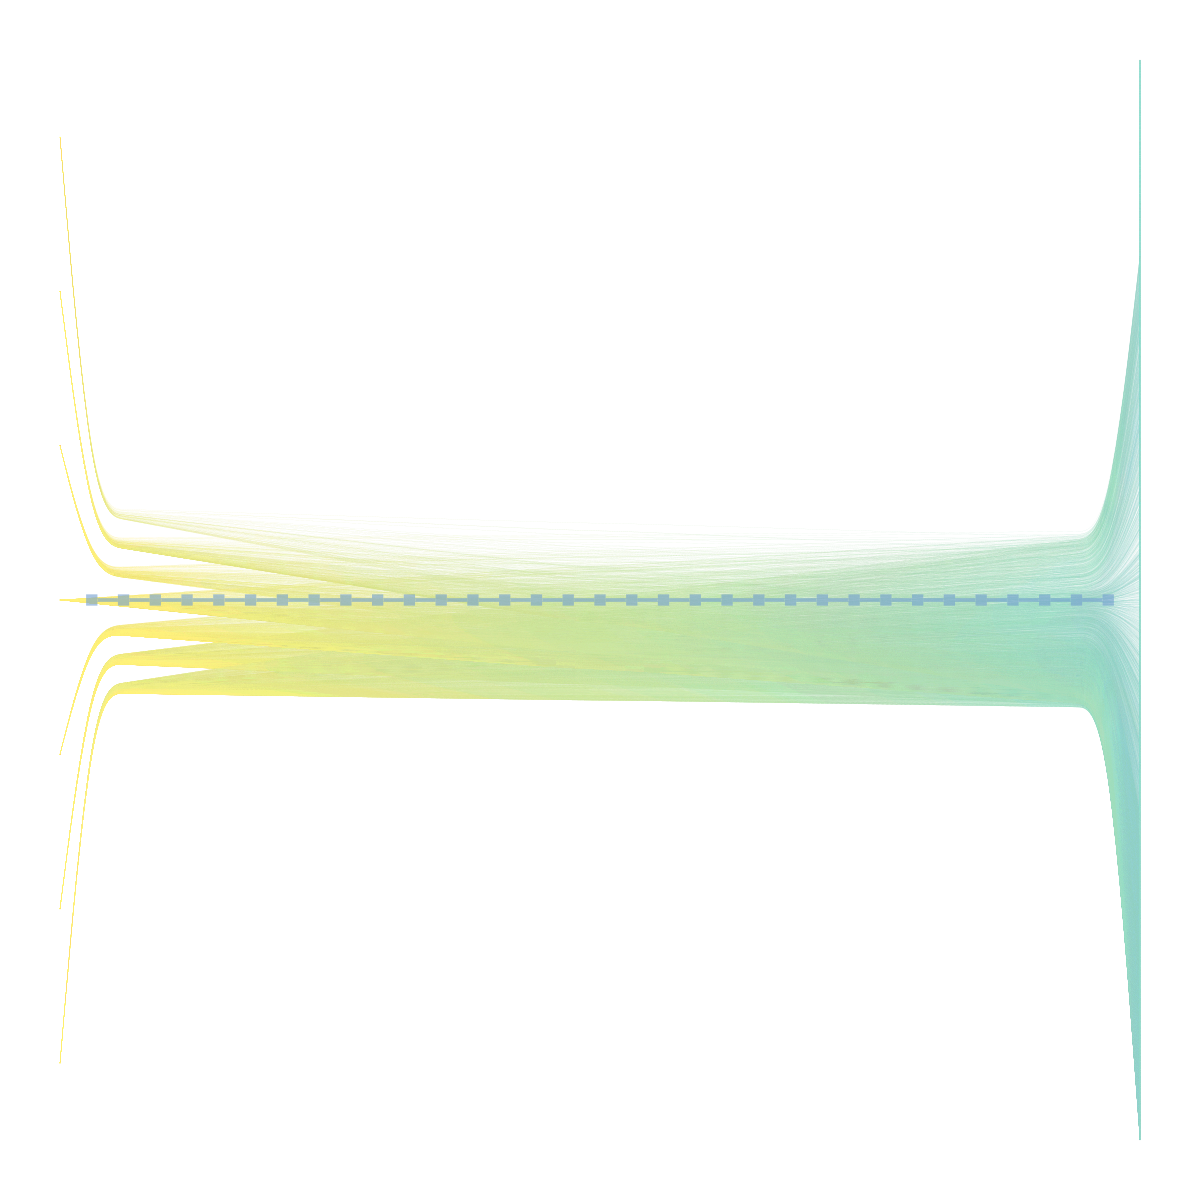

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f0a544953d0, at 0x7f0a30c58d90>,
 <GraphView object, directed, with 38457 vertices and 38456 edges, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7f0a30c58400, at 0x7f0a30c69730>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7f0a30c58400, at 0x7f0a30c694c0>, False), at 0x7f0a30c58400>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f0a30c58400, at 0x7f0a544a6eb0>)

In [7]:
new_state.draw(layout="bipartite",subsample_edges=6000,bip_aspect=1, hvertex_size=8, hedge_pen_width=1.9, output_size=(600, 600))

In [8]:
for i_n_init in range(10):
    base_type = gt.BlockState
    state_tmp = gt.minimize_nested_blockmodel_dl(graph,
                                                state_args=dict(
                                                    base_type=base_type,
                                                    **{'clabel': state_0.g.vp['kind'], 'pclabel': state_0.g.vp['kind']}),
                                                multilevel_mcmc_args=dict(
                                                    verbose=False))
    L = 0
    for s in state_tmp.levels:
        L += 1
        if s.get_nonempty_B() == 2:
            break
    state_tmp = state_tmp.copy(bs=state_tmp.get_bs()[:L] + [np.zeros(1)])

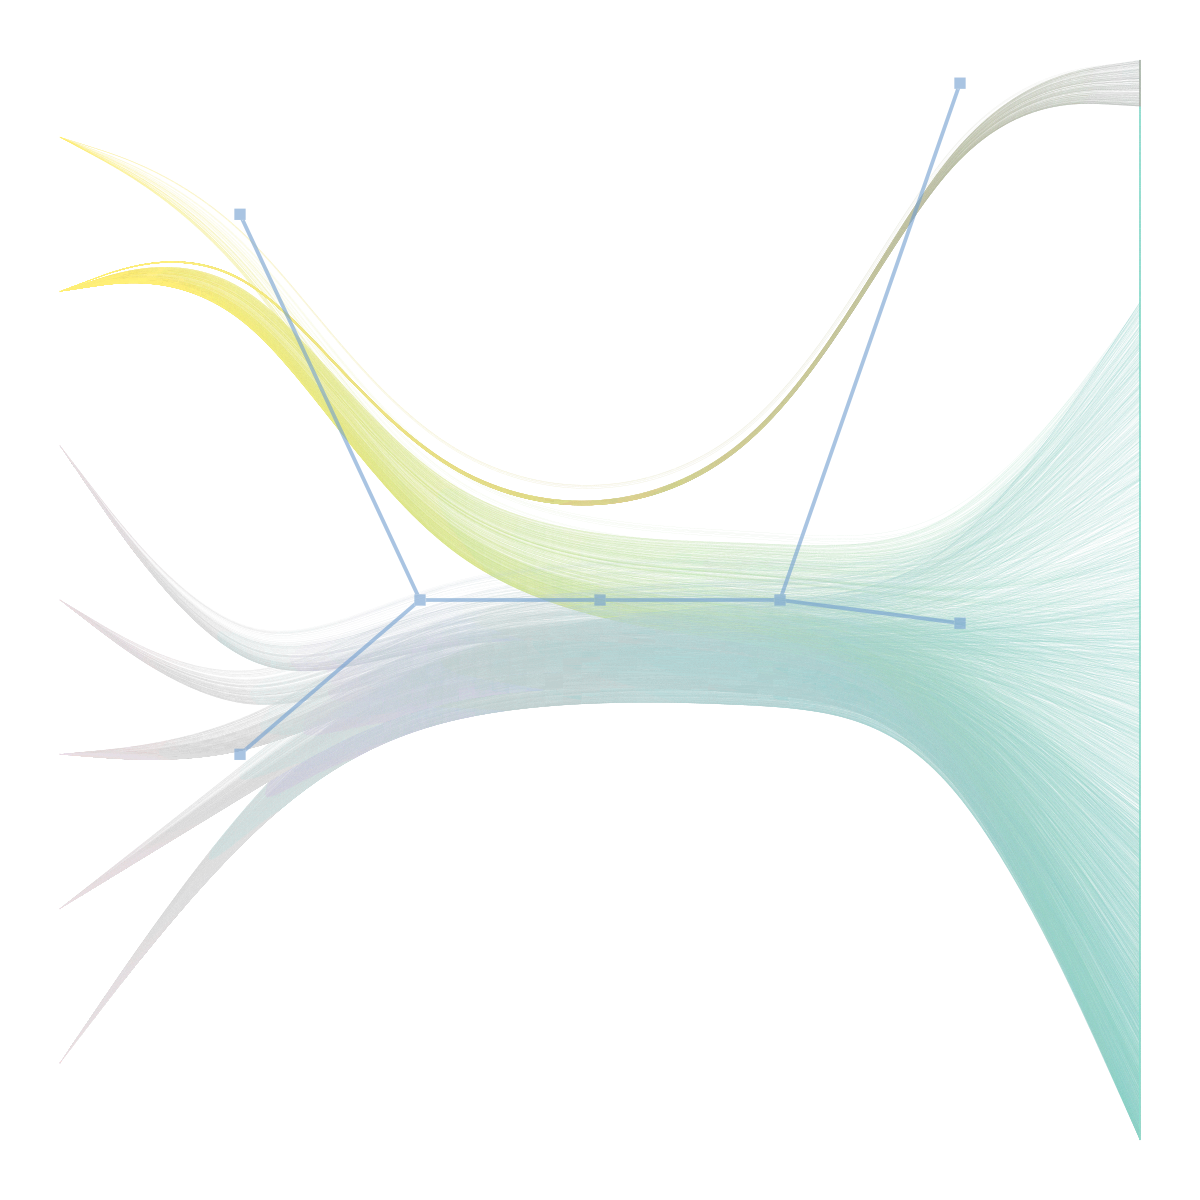

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f0a544953d0, at 0x7f0a544904f0>,
 <GraphView object, directed, with 38431 vertices and 38430 edges, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7f0a041541f0, at 0x7f0a04125880>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7f0a041541f0, at 0x7f0a305e7190>, False), at 0x7f0a041541f0>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f0a041541f0, at 0x7f0a30ecd280>)

In [9]:
state_tmp.draw(layout="bipartite",subsample_edges=6000,bip_aspect=1, hvertex_size=8, hedge_pen_width=1.9, output_size=(600, 600))

In [10]:
def index_array(which_model,clabel):
    array = [i for i in range(len(which_model.get_clabel(l=0).a)) if which_model.get_clabel(l=0).a[i] == clabel]
    return array

In [11]:
state_tmp.g.get_all_neighbors(800)

array([38422])

In [12]:
for v in model.state.g.vertices():
    if state.g.vp['kind'][v]==1:
        print('name: %s , index: %d' % (state.g.vp['name'][v], v))

name: 25-44 , index: 38417
name: F , index: 38418
name: 45-64 , index: 38419
name: M , index: 38420
name: cardiac_arrhythmias , index: 38421
name: 16-24 , index: 38422
name: valvular_disease , index: 38423


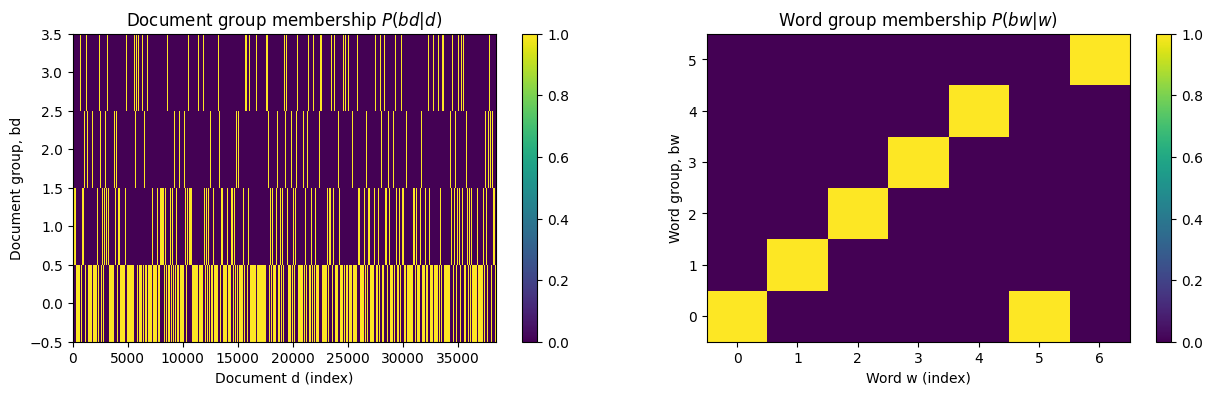

In [13]:
p_td_d,p_tw_w = model.group_membership(l=0)

plt.figure(figsize=(15,4))
plt.subplot(121)
plt.imshow(p_td_d,origin='lower',aspect='auto',interpolation='none')
plt.title(r'Document group membership $P(bd | d)$')
plt.xlabel('Document d (index)')
plt.ylabel('Document group, bd')
plt.colorbar()

plt.subplot(122)
plt.imshow(p_tw_w,origin='lower',aspect='auto',interpolation='none')
plt.title(r'Word group membership $P(bw | w)$')
plt.xlabel('Word w (index)')
plt.ylabel('Word group, bw')
plt.colorbar()

In [14]:
copy_state = state.copy(g=graph)

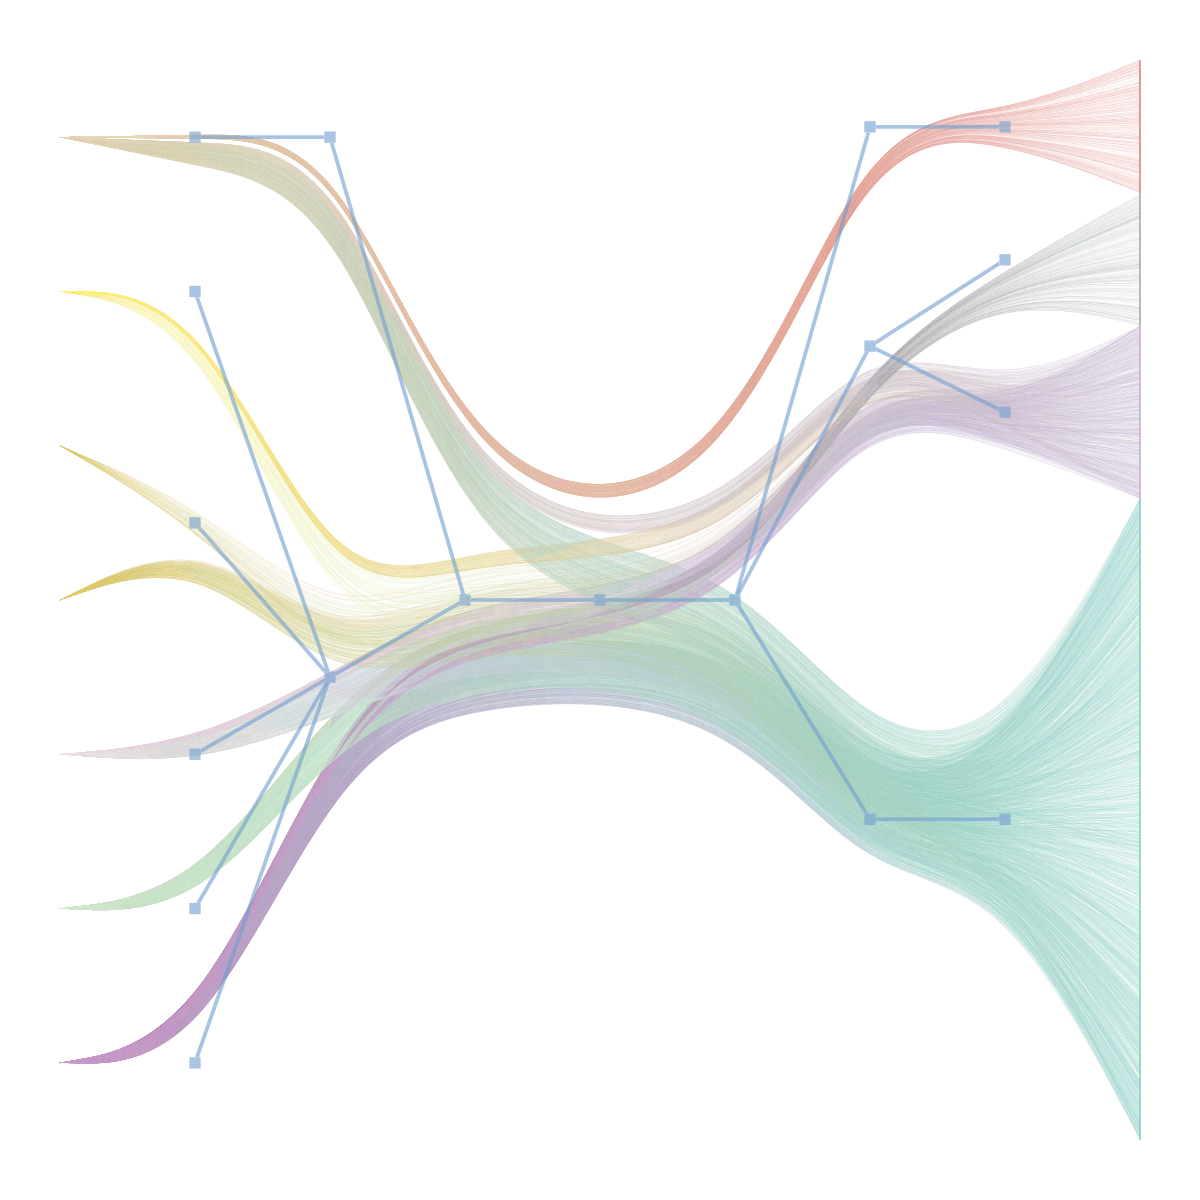

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f0a544a6f40, at 0x7f0a30e4cc70>,
 <GraphView object, directed, with 38442 vertices and 38441 edges, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7f0a3096c820, at 0x7f0a30d32d30>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7f0a3096c820, at 0x7f0a3096cd60>, False), at 0x7f0a3096c820>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f0a3096c820, at 0x7f0a30e4ceb0>)

In [16]:
state.draw(layout="bipartite",subsample_edges=6000,bip_aspect=1, hvertex_size=8, hedge_pen_width=1.9, output_size=(600, 600))

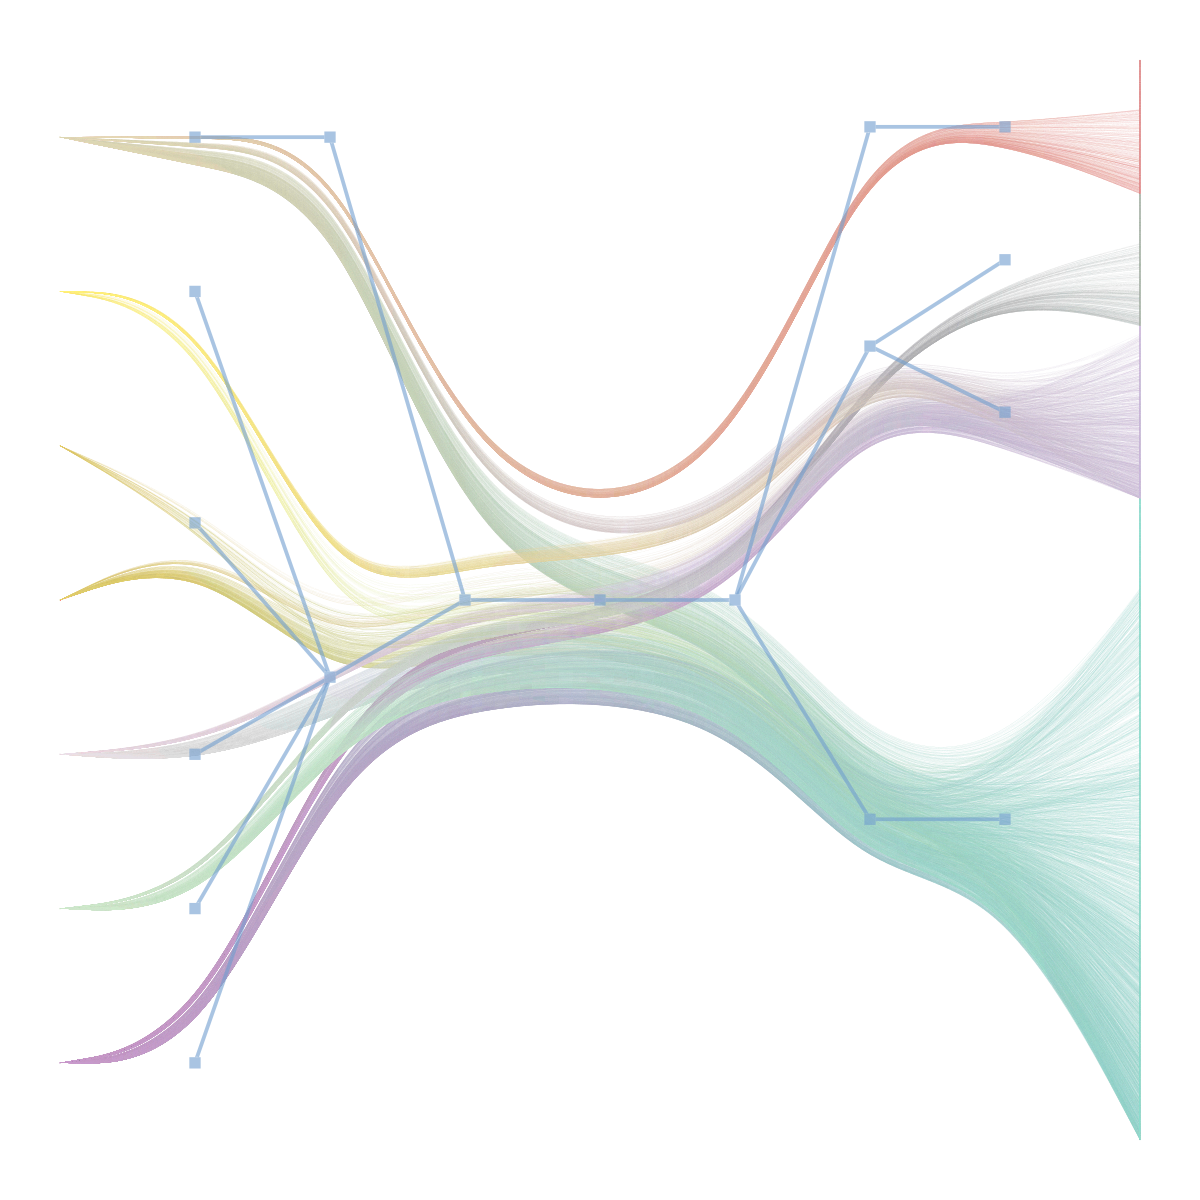

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f0a544953d0, at 0x7f0a3060e430>,
 <GraphView object, directed, with 38442 vertices and 38441 edges, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7f0a3060ec40, at 0x7f0a30d6fbe0>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7f0a3060ec40, at 0x7f0a30d20520>, False), at 0x7f0a3060ec40>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f0a3060ec40, at 0x7f0a0411f190>)

In [17]:
copy_state.draw(layout="bipartite",subsample_edges=6000,bip_aspect=1, hvertex_size=8, hedge_pen_width=1.9, output_size=(600, 600))

In [18]:
model.clusters(l=0,n=5)

{0: [('100001', 1.0),
  ('118228', 1.0),
  ('154871', 1.0),
  ('118259', 1.0),
  ('118258', 1.0)],
 1: [('199999', 1.0),
  ('152411', 1.0),
  ('152376', 1.0),
  ('152360', 1.0),
  ('152358', 1.0)],
 2: [('126439', 1.0),
  ('109735', 1.0),
  ('139237', 1.0),
  ('176689', 1.0),
  ('165193', 1.0)]}